# GAM Builder Demo

This notebook demonstrates the new formula-based GamBuilder interface for building GAMs with liesel_gam.

## Setup and Imports

In [1]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as lgam

In [2]:
from scipy import stats

rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)

log_sigma = -1.0 + 0.3 * (
    0.5 * x + 15 * stats.norm.pdf(2 * (x - 0.2)) - stats.norm.pdf(x + 0.4)
)
mu = -x + np.pi * np.sin(np.pi * x)
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x})

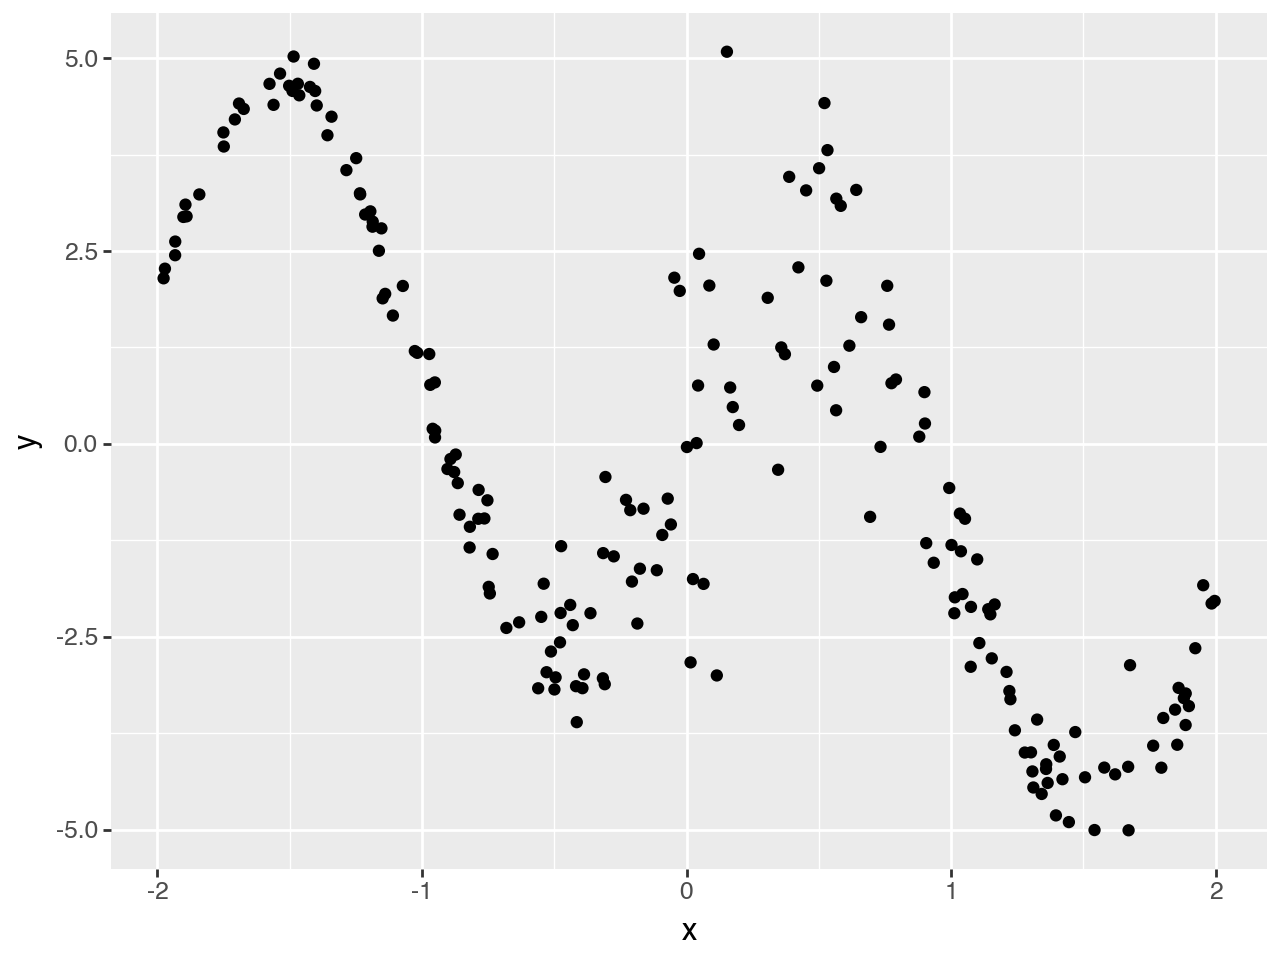

In [3]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Model Definition

The GamBuilder provides R-like formula syntax for building GAMs:
- Intercept control: `1` (include) or `0` (exclude). When using predictors we include a intercept by default
- Linear effects: `x1 + x2`
- `s()` terms use R's mgcv package via smoothcon (requires R installation)
- `ls()` terms use liesel's native P-splines implementation
- `factor()` terms are used for categorical variables, e.g., `factor(x_cat)` for a categorical variable `x_cat`
- `custom()` terms are allowed for custom functions registered when initiating the GamBuilder

Here we build a distributional GAM with smooth effects on both location and scale parameters.

In [4]:
constructor = lgam.GamBuilder(df)


loc = constructor.predictor("s(x)", name="$\\mu$")
scale = constructor.predictor("s(x)", name="$\\sigma$", inv_link=jnp.exp)
y = constructor.response("y", distribution=tfd.Normal, loc=loc, scale=scale)
model = lsl.Model([y])

liesel.model.model - INFO - Converted dtype of Value(name="").value
liesel.model.model - INFO - Converted dtype of Value(name="").value


Here we build a distributional GAM with smooth effects on both location and scale parameters. The Constructor uses semantic naming with predictor prefixes (e.g., `mu_s(x)`, `sigma_s(x)`).

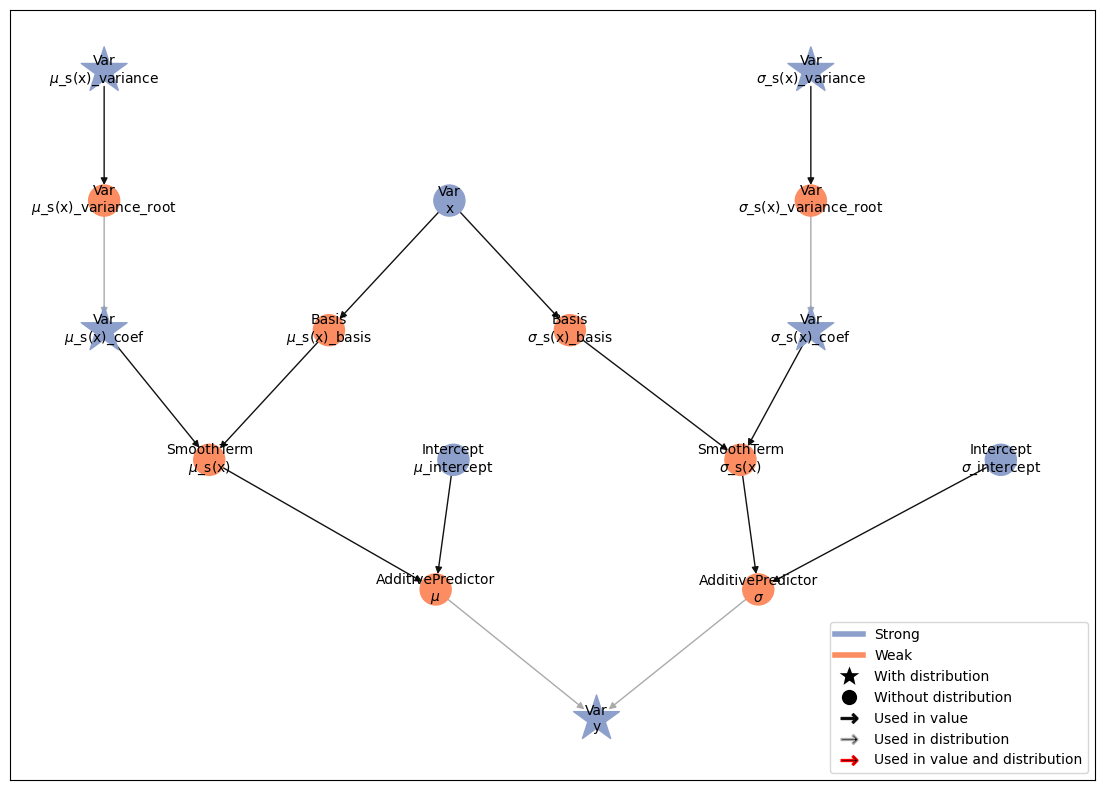

In [5]:
model.plot_vars()

### Custom Term Naming

The GamBuilder supports custom naming for better interpretability. Most functions accept the `name` keyword parameter to set the term's name in the model. This is useful for complex models where you want to keep track of different terms easily.

liesel.model.model - INFO - Converted dtype of Value(name="").value
liesel.model.model - INFO - Converted dtype of Value(name="").value


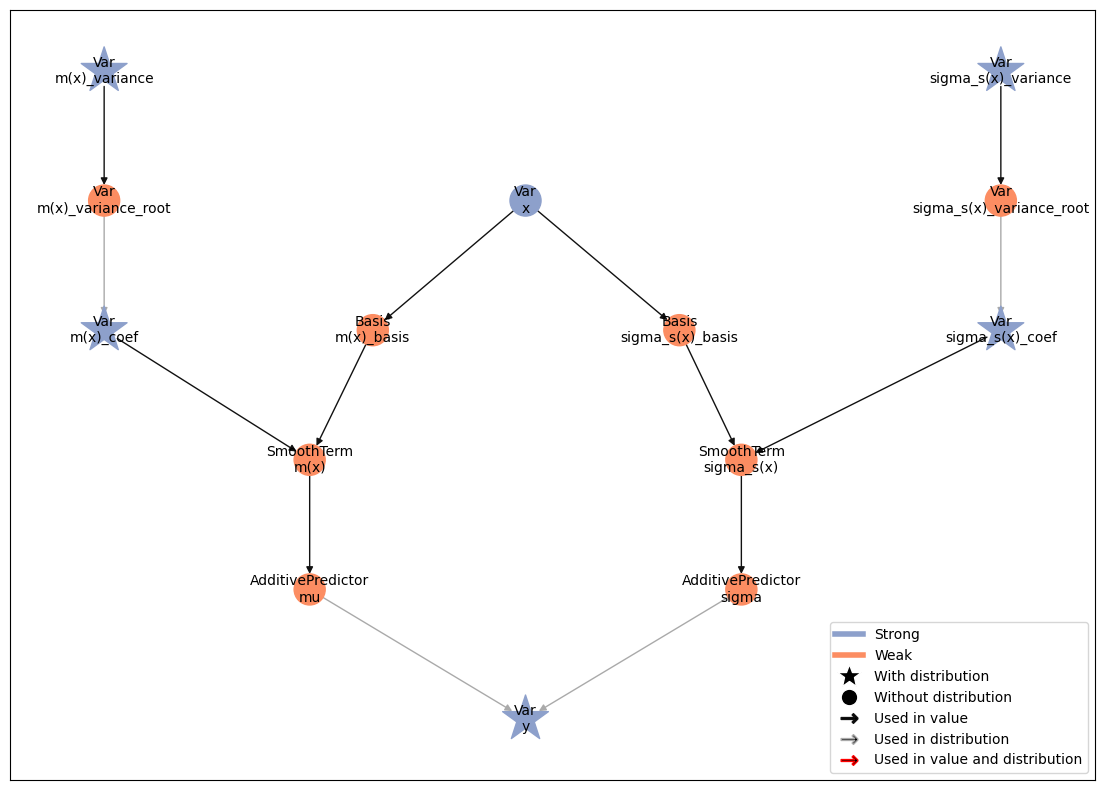

In [6]:
constructor = lgam.GamBuilder(df)
loc = constructor.predictor("0 + s(x, name='m(x)')", name="mu")
scale = constructor.predictor("0 + s(x)", name="sigma", inv_link=jnp.exp)
y = constructor.response("y", distribution=tfd.Normal, loc=loc, scale=scale)
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

The GAM constructor automatically sets up IWLS and Gibbs kernels for all parameters, making MCMC setup straightforward.

In [7]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys 'sigma_s(x)_coef', 'sigma_s(x)_variance', 'm(x)_coef', 'm(x)_variance'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:01<00:00,  8.25chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 363.52chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 0, 1, 1, 1 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|█████████████████████████████████████████| 2/2 [00:00<00:00, 383.67chu

### MCMC summary

In [8]:
summary = gs.Summary(results)
summary

Parameter summary:

                              kernel        mean          sd      q_0.05  \
parameter           index                                                  
m(x)_coef           (0,)   kernel_02    7.127658    4.449061   -0.169693   
                    (1,)   kernel_02   -1.997715    5.274708  -10.701385   
                    (2,)   kernel_02   10.036778    3.794769    3.694204   
                    (3,)   kernel_02    2.088920    3.158435   -3.162125   
                    (4,)   kernel_02  -62.828690    2.066545  -66.210006   
                    (5,)   kernel_02   -2.197252    1.106707   -4.013779   
                    (6,)   kernel_02   -3.981915    0.574513   -4.895230   
                    (7,)   kernel_02   -0.533142    1.420919   -2.853409   
                    (8,)   kernel_02   25.318668    1.587588   22.715368   
                    (9,)   kernel_02    4.764203    2.345033    0.931062   
m(x)_variance       ()     kernel_03  693.926025  455.574432  266.022324   
sigma_s(x)_coef     (0,)   kernel_00   -0.742742    3.233928   -6.175999   
                    (1,)   kernel_00    0.468490    2.816005   -4.014844   
                    (2,)   kernel_00   -1.662590    2.718983   -6.254004   
                    (3,)   kernel_00    1.487788    2.092242   -1.903528   
                    (4,)   kernel_00   -4.549971    1.884425   -7.754639   
                    (5,)   kernel_00    5.228364    0.832419    3.852988   
                    (6,)   kernel_00    0.171437    0.914760   -1.287188   
                    (7,)   kernel_00    1.208939    1.678585   -1.497138   
                    (8,)   kernel_00    2.434452    2.070566   -0.977252   
                    (9,)   kernel_00   -1.579695    3.062637   -6.595556   
sigma_s(x)_variance ()     kernel_01   15.601689   14.647752    3.921369   

                                q_0.5       q_0.95  sample_size     ess_bulk  \
parameter           index                                                      
m(x)_coef           (0,)     7.253126    14.444895         4000  3548.513025   
                    (1,)    -2.000212     6.731245         4000  3637.408926   
                    (2,)     9.971794    16.214505         4000  3681.676865   
                    (3,)     2.099767     7.280889         4000  3696.996243   
                    (4,)   -62.840200   -59.352624         4000  3797.273169   
                    (5,)    -2.177348    -0.350659         4000  3943.389069   
                    (6,)    -3.989137    -3.023055         4000  3749.798954   
                    (7,)    -0.530840     1.841007         4000  3522.696112   
                    (8,)    25.324821    27.928282         4000  3680.647390   
                    (9,)     4.763051     8.570496         4000  3392.194791   
m(x)_variance       ()     576.801270  1496.188696         4000  4114.257256   
sigma_s(x)_coef     (0,)    -0.656422     4.409436         4000  1955.868699   
                    (1,)     0.410627     5.176266         4000  1872.475963   
                    (2,)    -1.603722     2.720457         4000  1734.629897   
                    (3,)     1.455671     4.964941         4000  1635.903965   
                    (4,)    -4.477347    -1.569387         4000  1309.794933   
                    (5,)     5.242350     6.573510         4000  1484.073832   
                    (6,)     0.163056     1.696232         4000  1732.486753   
                    (7,)     1.179534     3.980735         4000  1692.580380   
                    (8,)     2.417753     5.762896         4000  1724.626008   
                    (9,)    -1.493906     3.342382         4000  1695.866017   
sigma_s(x)_variance ()      11.831419    38.616544         4000  2202.041880   

                              ess_tail      rhat  
parameter           index                         
m(x)_coef           (0,)   3800.083017  1.000092  
                    (1,)   3623.812018  1.000114  
                    (2,)   383

### MCMC trace plots

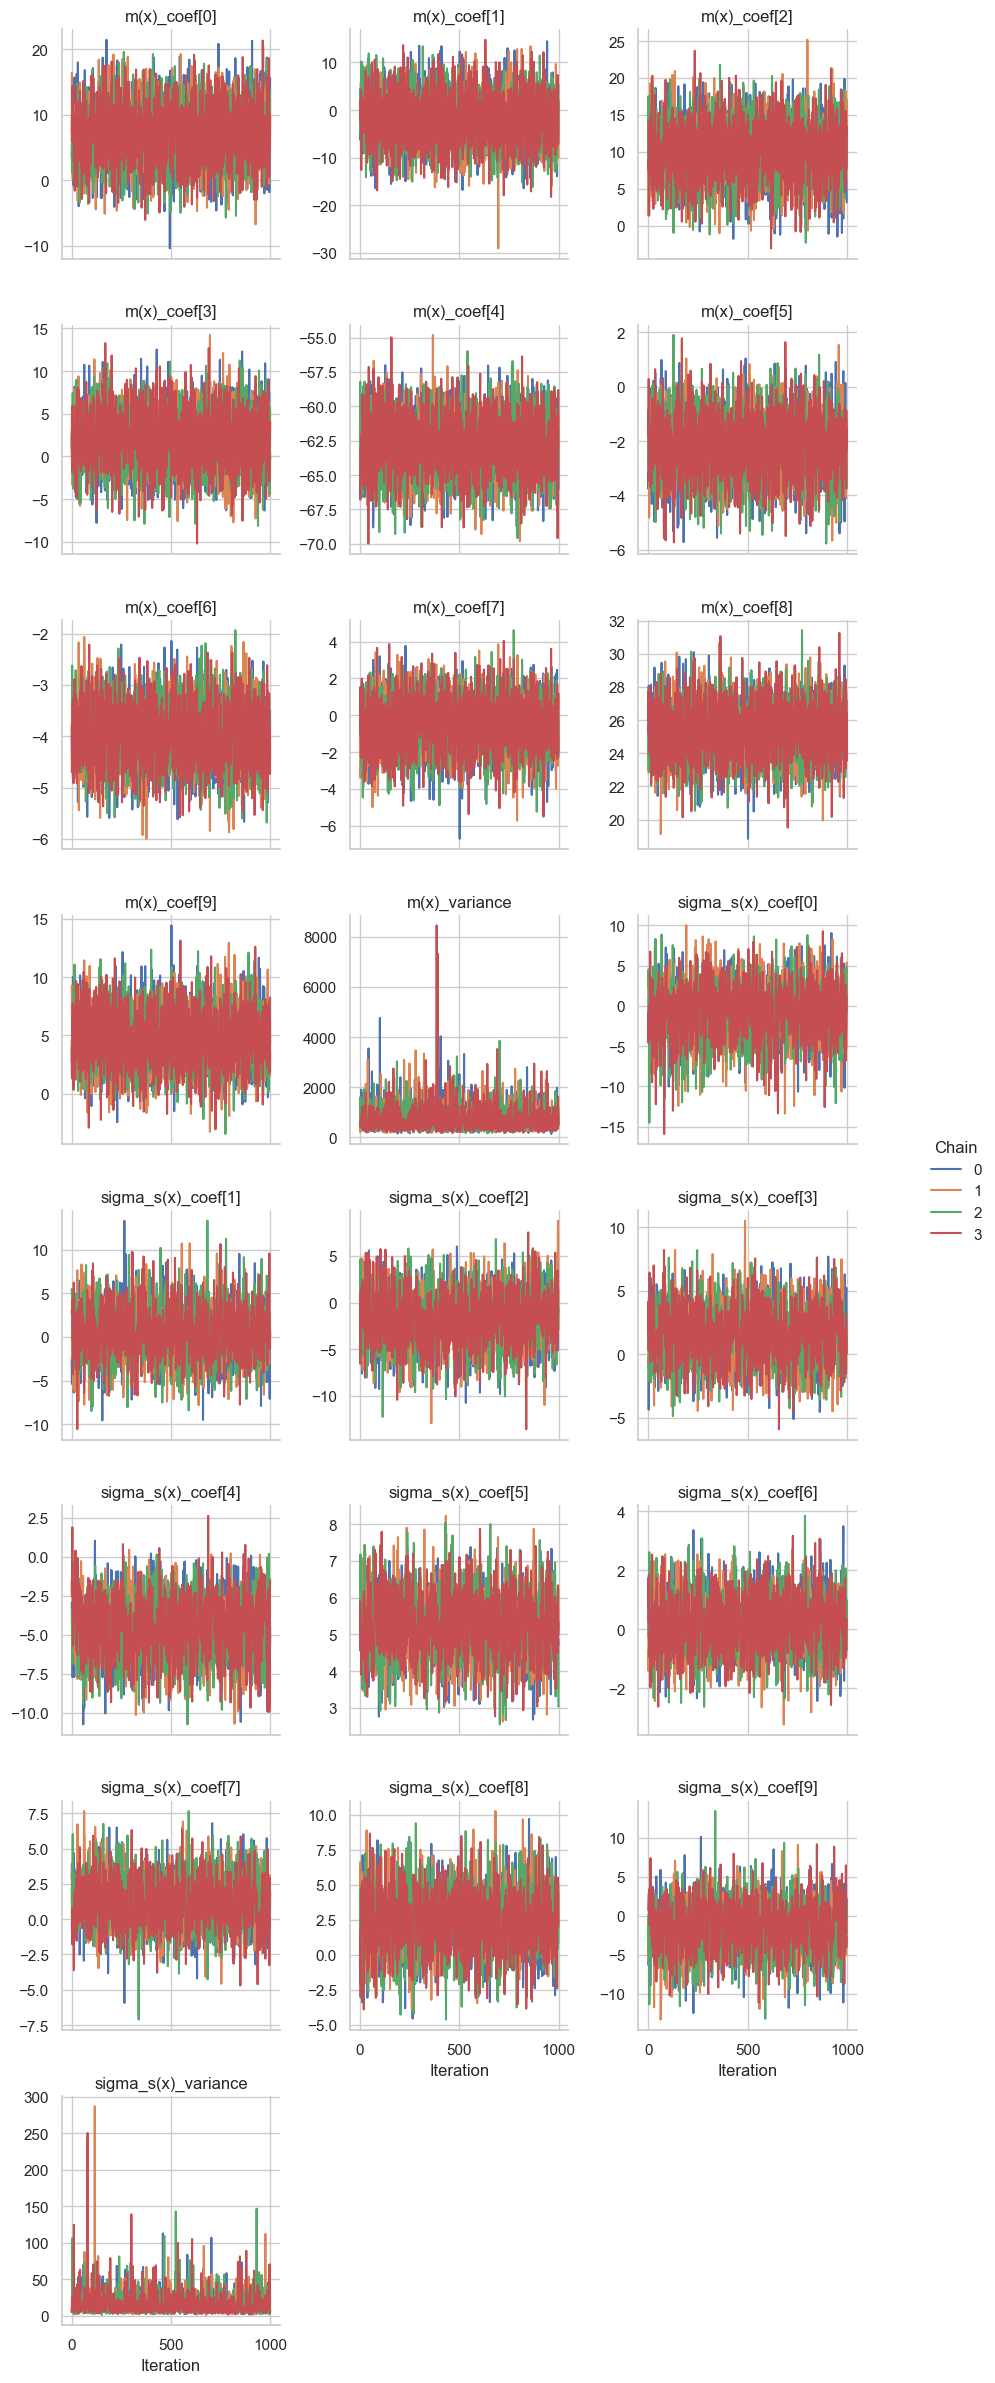

In [9]:
gs.plot_trace(results)

## Predictions

In [10]:
samples = results.get_posterior_samples()

### Prediction Grid

In [11]:
x_grid = jnp.linspace(x.min(), x.max(), 300)

### Model Predictions

In [12]:
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["m(x)", "sigma_s(x)", "mu", "sigma"],
    newdata={"x": x_grid},
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0
predictions_summary["x"] = np.tile(x_grid, len(predictions))

In [13]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,rhat,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x
0,m(x),m(x)[0],"(0,)",4000,2.223456,0.002443,0.049422,1.000310,3841.862335,3107.132948,0.000796,0.000750,2.141713,2.224183,2.303556,2.139739,2.301416,-1.976702
1,m(x),m(x)[1],"(1,)",4000,2.333046,0.002162,0.046501,1.000370,3865.521618,3190.266626,0.000747,0.000708,2.255927,2.333560,2.409001,2.258535,2.410684,-1.963415
2,m(x),m(x)[2],"(2,)",4000,2.442556,0.001916,0.043768,1.000501,3883.870574,3248.428467,0.000702,0.000666,2.369640,2.443202,2.512973,2.369464,2.512503,-1.950128
3,m(x),m(x)[3],"(3,)",4000,2.551892,0.001702,0.041260,1.000798,3903.013503,3164.700163,0.000660,0.000625,2.482163,2.552735,2.618586,2.486846,2.622627,-1.936841
4,m(x),m(x)[4],"(4,)",4000,2.660954,0.001522,0.039018,1.001043,3920.041323,3273.684454,0.000623,0.000584,2.595217,2.661717,2.724160,2.600221,2.727463,-1.923554


### Plot fitted functions

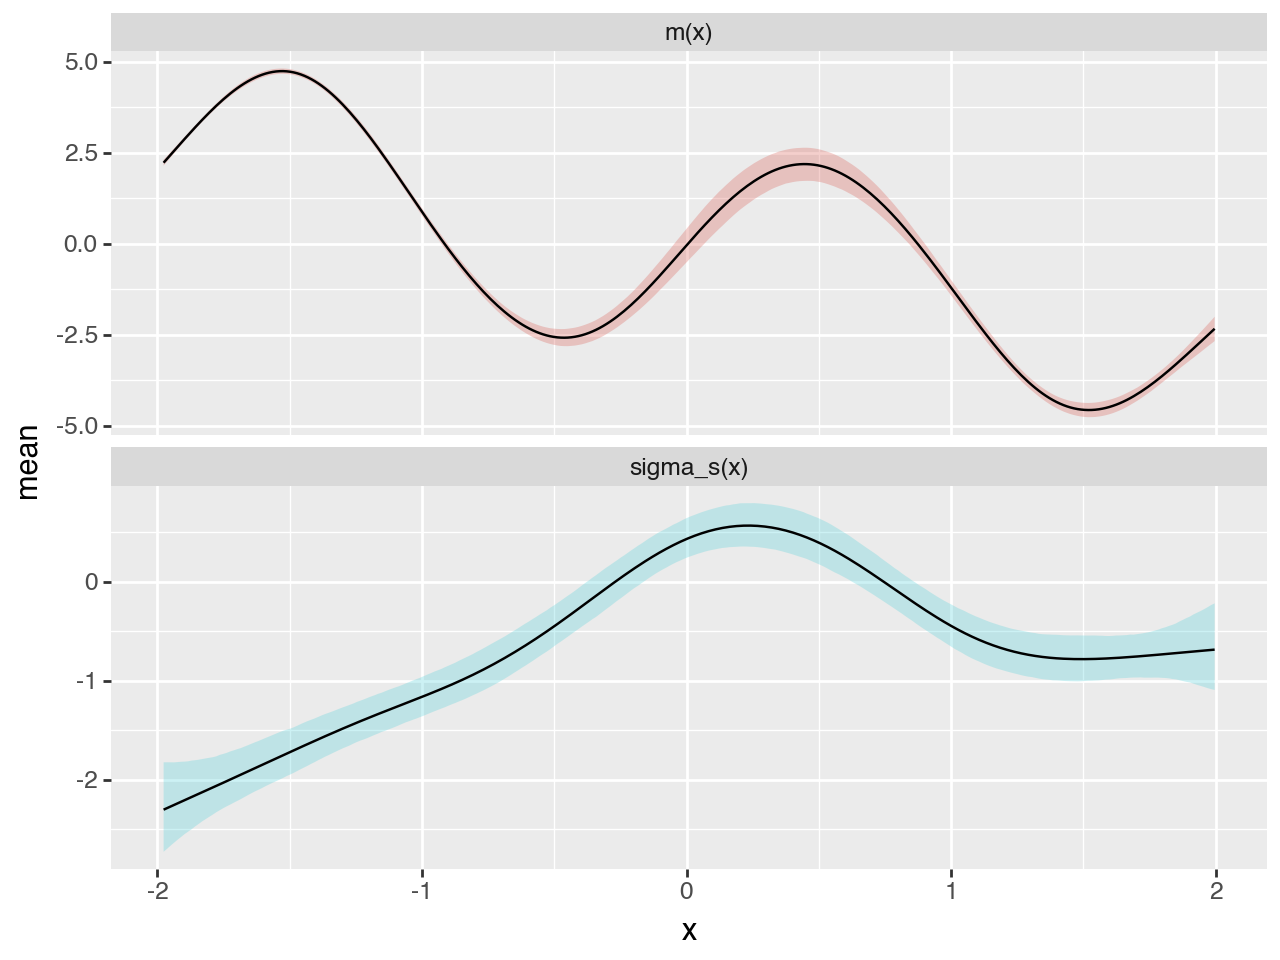

In [14]:
select = predictions_summary["variable"].isin(["m(x)", "sigma_s(x)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot parameters as functions of covariate

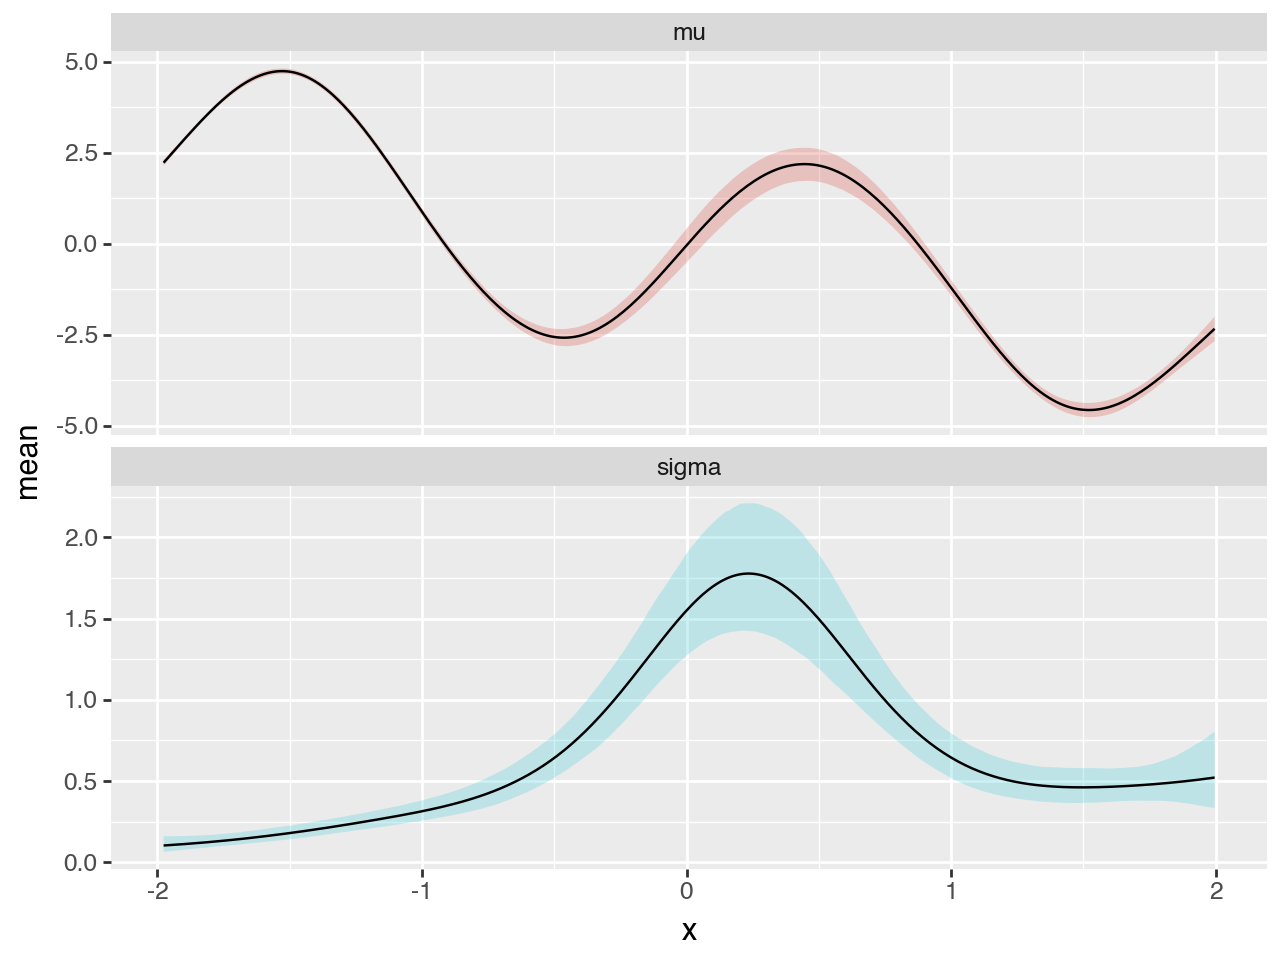

In [15]:
select = predictions_summary["variable"].isin(["mu", "sigma"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot mean function with data

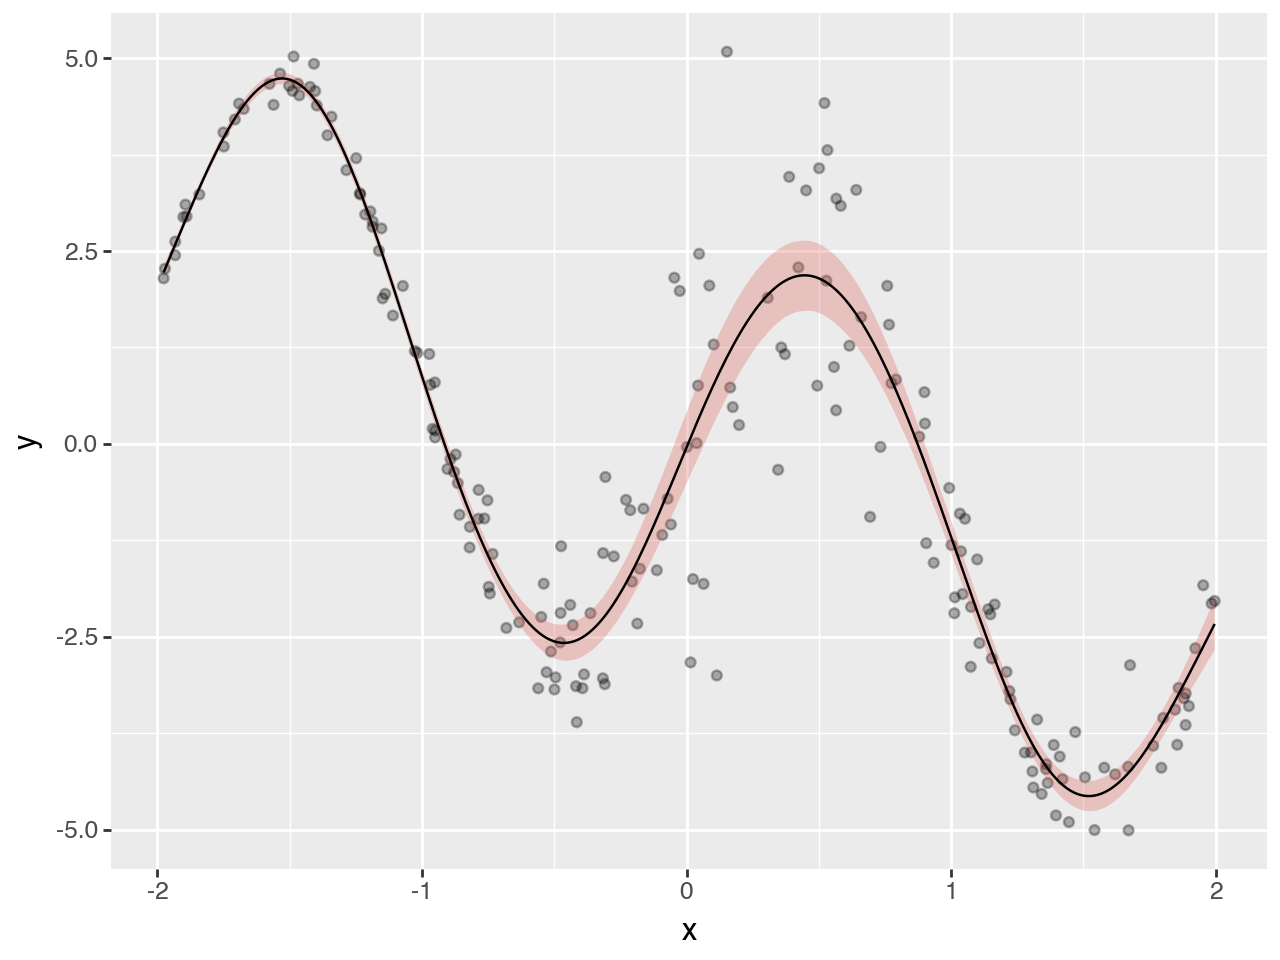

In [16]:
select = predictions_summary["variable"].isin(["mu"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.guides(fill="none")
)

### Plot average posterior predictive distribution

In [17]:
select = predictions_summary["variable"].isin(["mu", "sigma"])
mu_sigma_df = (
    predictions_summary[select][["variable", "mean", "x"]]
    .pivot(index="x", columns=["variable"], values="mean")
    .reset_index()
)

mu_sigma_df["low"] = mu_sigma_df["mu"] - mu_sigma_df["sigma"]
mu_sigma_df["high"] = mu_sigma_df["mu"] + mu_sigma_df["sigma"]
mu_sigma_df

variable,x,mu,sigma,low,high
0,-1.976702,2.223456,0.103907,2.119549,2.327363
1,-1.963415,2.333046,0.105309,2.227737,2.438355
2,-1.950128,2.442556,0.106745,2.335812,2.549301
3,-1.936841,2.551892,0.108216,2.443676,2.660108
4,-1.923554,2.660954,0.109722,2.551232,2.770677
...,...,...,...,...,...
295,1.942956,-2.693562,0.510465,-3.204027,-2.183096
296,1.956243,-2.603853,0.513230,-3.117083,-2.090623
297,1.969530,-2.513959,0.516079,-3.030038,-1.997880
298,1.982817,-2.423975,0.519015,-2.942990,-1.904960


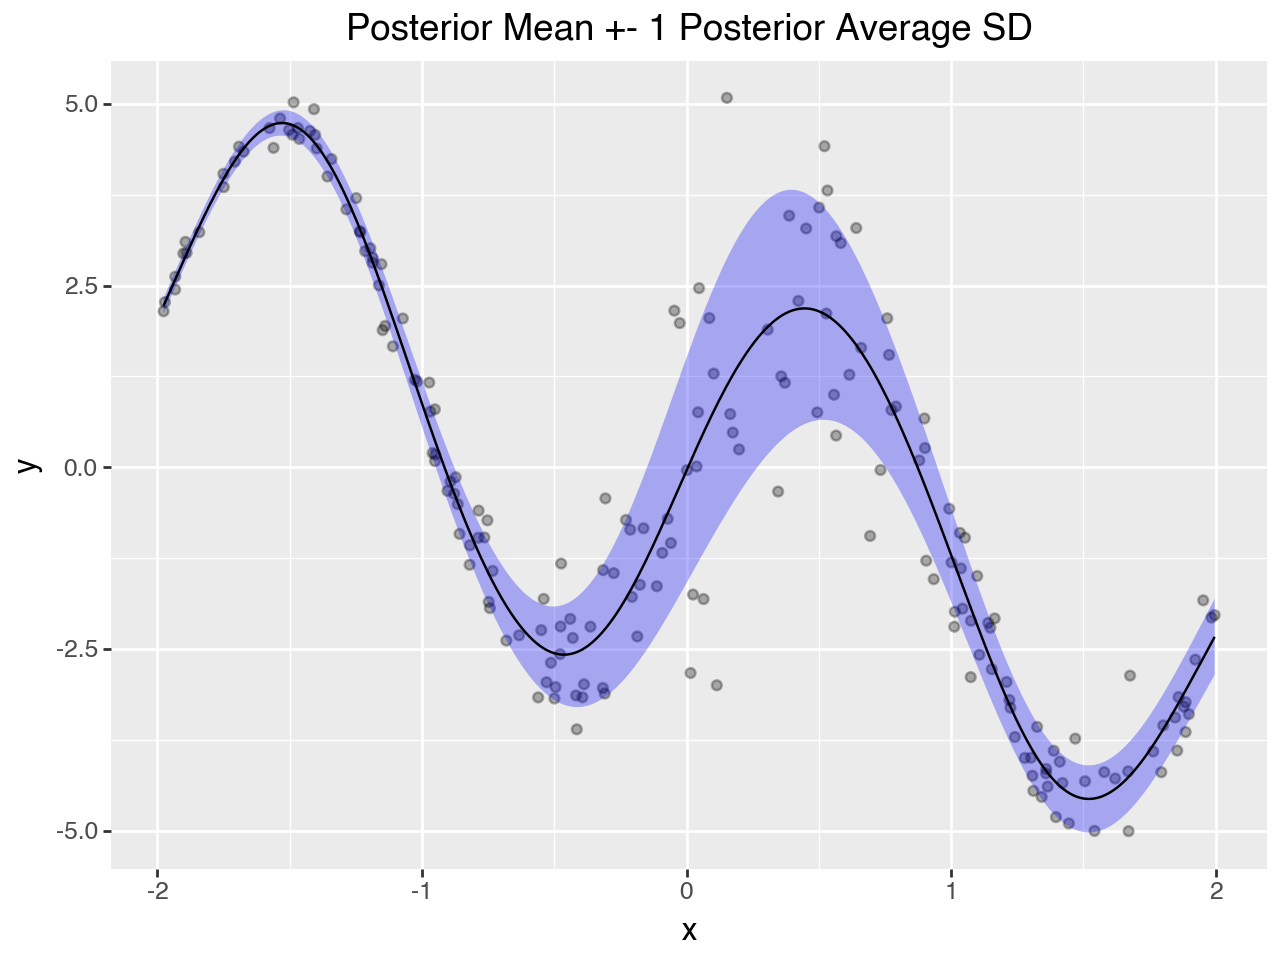

In [18]:
(
    p9.ggplot()
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="low", ymax="high"),
        alpha=0.3,
        fill="blue",
        data=mu_sigma_df,
    )
    + p9.geom_line(p9.aes("x", "mu"), data=mu_sigma_df)
    + p9.labs(title="Posterior Mean +- 1 Posterior Average SD")
    + p9.guides(fill="none")
)

## Posterior Predictive Checks

### Draw posterior predictive samples

In [19]:
ppsamples = model.sample(  # new in liesel v0.4.0
    shape=(3,), seed=jax.random.key(1), posterior_samples=samples
)

ppsamples["y"].shape

(3, 4, 1000, 200)

In [20]:
# can be reshaped to concatenate the first two axes
_ = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])

### Summarize posterior predictive samples

In [21]:
ppsamples = model.sample(
    shape=(),  # just draw 1 value for each posterior sample
    seed=jax.random.key(1),
    posterior_samples=samples,
)

# summarise ppsamples
ppsamples_summary = gs.SamplesSummary(ppsamples).to_dataframe().reset_index()

# add covariate to df
ppsamples_summary["x"] = df["x"].to_numpy()

### Plot posterior predictive summary

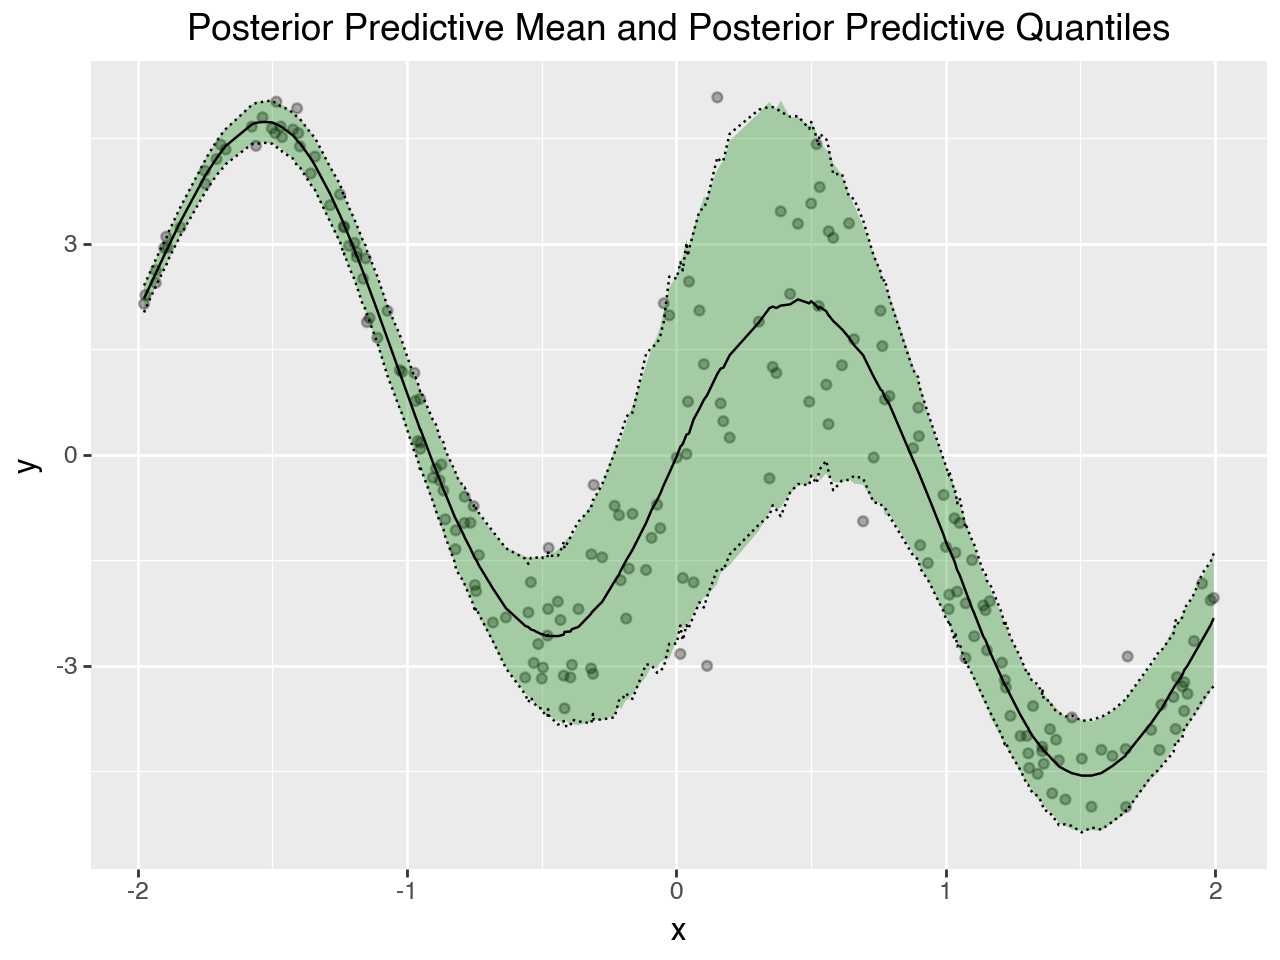

In [22]:
(
    p9.ggplot(ppsamples_summary)
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
    )
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.labs(title="Posterior Predictive Mean and Posterior Predictive Quantiles")
    + p9.guides(fill="none")
)

### Plot posterior predictive samples

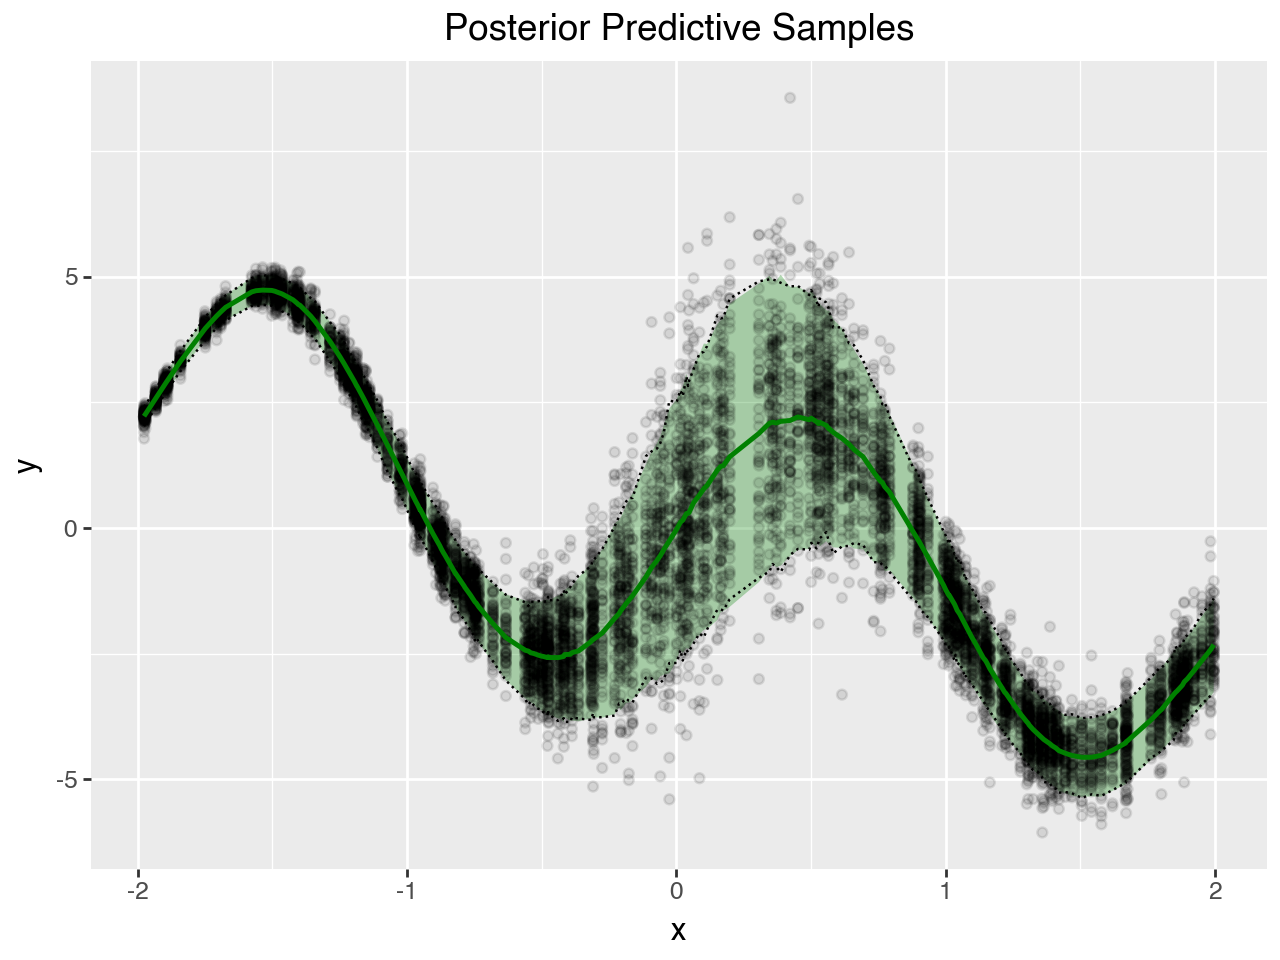

In [23]:
ppsamples_reshaped = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])
ppsamples_df = pd.DataFrame(ppsamples_reshaped.T)
ppsamples_df["x"] = df["x"].to_numpy()
ppsamples_df = ppsamples_df.melt(id_vars=["x"], value_name="y", var_name="sample")
ppsamples_df[ppsamples_df["sample"].isin(range(5))]


nsamples = 50


(
    p9.ggplot(ppsamples_df[ppsamples_df["sample"].isin(range(nsamples))])
    + p9.labs(title="Posterior Predictive Samples")
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
        data=ppsamples_summary,
    )
    + p9.geom_point(p9.aes("x", "y"), alpha=0.1)
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "mean"), color="green", size=1, data=ppsamples_summary)
)

## Include a categorical variable

In [24]:
rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)
x_cat = 1 * (rng.uniform(0, 1, 200) > 0.5)

log_sigma = -1.0 + 0.3 * (
    0.5 * x + 15 * stats.norm.pdf(2 * (x - 0.2)) - stats.norm.pdf(x + 0.4)
)
mu = -x + np.pi * np.sin(np.pi * x) + 0.5 * x_cat
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x, "x_cat": pd.Categorical(x_cat)})

liesel.model.model - INFO - Converted dtype of Value(name="").value
liesel.model.model - INFO - Converted dtype of Value(name="").value


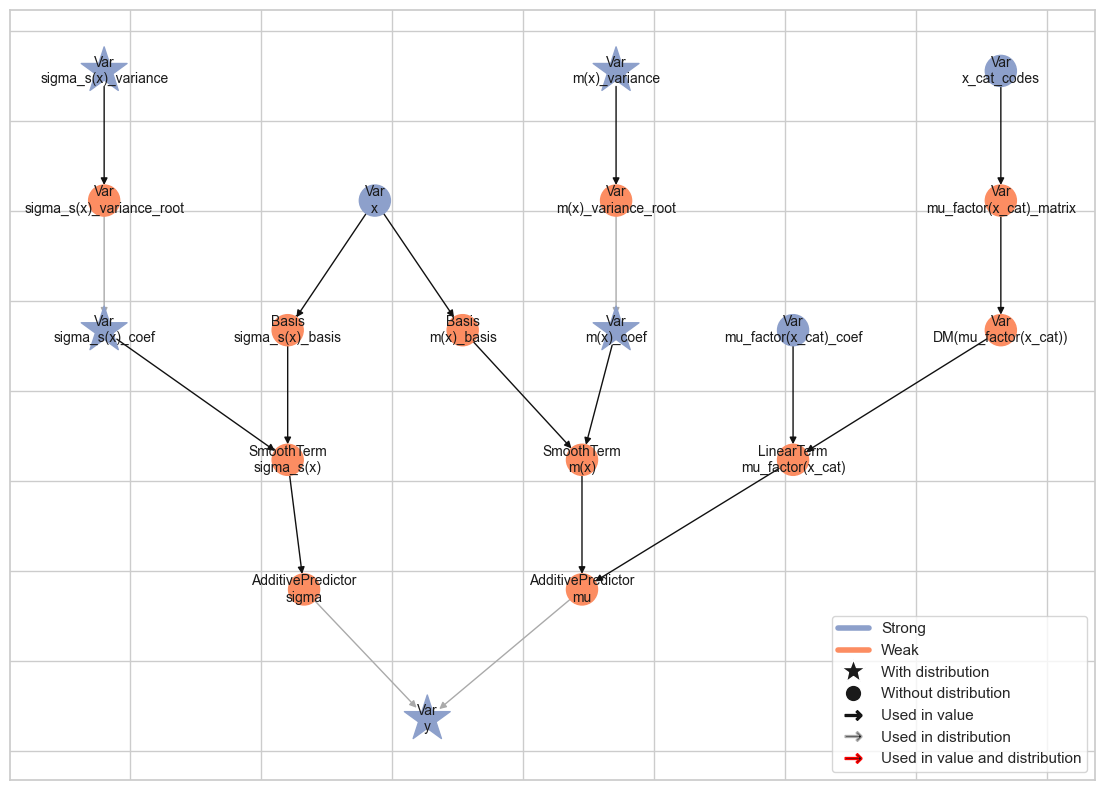

In [25]:
constructor = lgam.GamBuilder(df)
loc = constructor.predictor("0 + factor(x_cat) + s(x, name='m(x)')", name="mu")
scale = constructor.predictor("0 + s(x)", name="sigma", inv_link=jnp.exp)
y = constructor.response("y", distribution=tfd.Normal, loc=loc, scale=scale)
model = lsl.Model([y])
model.plot_vars()

In [26]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()
summary = gs.Summary(results)
summary

liesel.goose.builder - WARNING - No jitter functions provided for position keys 'sigma_s(x)_coef', 'sigma_s(x)_variance', 'm(x)_coef', 'm(x)_variance', 'mu_factor(x_cat)_coef'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:02<00:00,  6.81chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 300.13chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 0, 0, 0, 1 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|█████████████████████████████████████████| 2/

Parameter summary:

                                kernel        mean          sd      q_0.05  \
parameter             index                                                  
m(x)_coef             (0,)   kernel_02    4.134856    5.500224   -5.037412   
                      (1,)   kernel_02    1.701499    5.573493   -7.458001   
                      (2,)   kernel_02   15.052419    4.073784    8.317458   
                      (3,)   kernel_02   -8.691436    3.383534  -14.292005   
                      (4,)   kernel_02  -66.368637    2.144451  -69.908902   
                      (5,)   kernel_02   -4.046838    1.150203   -5.932787   
                      (6,)   kernel_02   -3.612845    0.694784   -4.751313   
                      (7,)   kernel_02    2.513345    1.512385    0.091549   
                      (8,)   kernel_02   26.963352    1.830196   23.902771   
                      (9,)   kernel_02   -0.305696    2.614149   -4.584718   
m(x)_variance         ()     kernel_03  801.855713  528.618835  305.351288   
mu_factor(x_cat)_coef (0,)   kernel_04    0.471687    0.068901    0.360074   
sigma_s(x)_coef       (0,)   kernel_00    0.041552    3.000458   -4.780813   
                      (1,)   kernel_00   -1.245474    2.681683   -5.981865   
                      (2,)   kernel_00    2.334484    2.820019   -1.760233   
                      (3,)   kernel_00    1.874606    2.103455   -1.449294   
                      (4,)   kernel_00   -2.586633    1.758419   -5.642641   
                      (5,)   kernel_00    4.501165    0.821934    3.188168   
                      (6,)   kernel_00    1.550239    0.898836    0.112202   
                      (7,)   kernel_00    1.695488    1.596405   -0.791498   
                      (8,)   kernel_00    0.571465    2.035575   -2.614806   
                      (9,)   kernel_00   -2.744721    2.919809   -7.769405   
sigma_s(x)_variance   ()     kernel_01   13.120557   13.229179    2.905452   

                                  q_0.5       q_0.95  sample_size  \
parameter             index                                         
m(x)_coef             (0,)     4.291231    13.174558         4000   
                      (1,)     1.717760    10.843237         4000   
                      (2,)    15.041573    21.726039         4000   
                      (3,)    -8.731221    -3.111607         4000   
                      (4,)   -66.411434   -62.776987         4000   
                      (5,)    -4.054607    -2.162228         4000   
                      (6,)    -3.624763    -2.445318         4000   
                      (7,)     2.485821     4.991565         4000   
                      (8,)    26.977205    30.007328         4000   
                      (9,)    -0.272937     3.856273         4000   
m(x)_variance         ()     663.483765  1722.494025         4000   
mu_factor(x_cat)_coef (0,)     0.470830     0.584699         4000   
sigma_s(x)_coef       (0,)     0.087583     5.072027         4000   
                      (1,)    -1.094745     2.934351         4000   
                      (2,)     2.069949     7.391318         4000   
                      (3,)     1.833813     5.398163         4000   
                      (4,)    -2.545171     0.191134         4000   
                      (5,)     4.503425     5.846177         4000   
                      (6,)     1.544156     3.033543         4000   
                      (7,)     1.602548     4.441667         4000   
                      (8,)     0.473515     4.048765         4000   
                      (9,)    -2.605414     1.829990         4000   
sigma_s(x)_variance   ()       9.542053    35.145648         4000   

                                ess_bulk     ess_tail      rhat  
parameter             index                                      
m(x)_coef             (0,)   3194.670078  3690.878622  0.999676  
                      (1,)   3516.440784  3614.636439  0.999928  
                      (2,)   3636.69001

In [30]:
# bug prevents the use of model.predict with different number of obs
# https://github.com/liesel-devs/liesel/issues/291
x_grid = jnp.linspace(x.min(), x.max(), 200)
x_cat_codes = jnp.zeros_like(x_grid, dtype=int)

predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["m(x)", "sigma_s(x)", "mu", "sigma"],
    newdata={"x": x_grid, "x_cat_codes": x_cat_codes},
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0
predictions_summary["x"] = np.tile(x_grid, len(predictions))

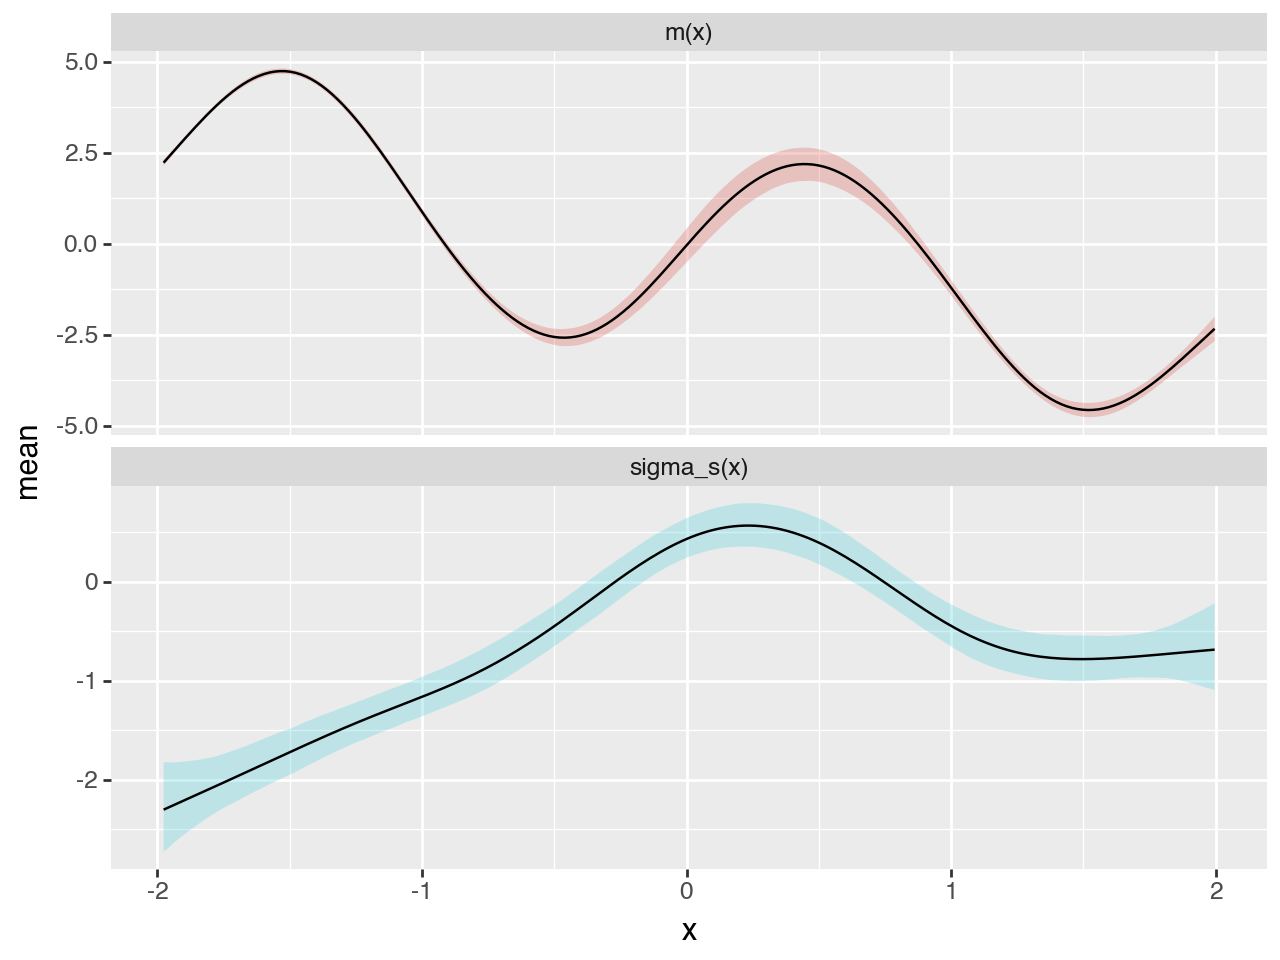

In [31]:
select = predictions_summary["variable"].isin(["m(x)", "sigma_s(x)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)